In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import cv2
import numpy as np
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, ToPILImage, v2, CenterCrop

class SkinDataset(Dataset):
    def __init__(self, root='/kaggle/input/huhuhu5/skintone/', train=True, transform=None):
        super().__init__()
        self.image_paths = []
        self.labels = []
        self.categories = ["dark", "light", "mid-dark", "mid-light"]
        self.transform = transform
        
        if train:
            data_path = os.path.join(root, 'train')
        else:
            data_path = os.path.join(root, 'valid')
        
        for i, category in enumerate(self.categories):
            data_files = os.path.join(data_path,category)
            for item in os.listdir(data_files):
                path = os.path.join(data_files,item)
                self.image_paths.append(path)
                self.labels.append(i)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [2]:
train_transform = Compose([
        ToPILImage(),
        Resize(256),
        CenterCrop(224),
#         ToTensor(),
        v2.RandomHorizontalFlip(p=0.5),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
test_transform = Compose([
        ToPILImage(),
        Resize(256),
        CenterCrop(224),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]) 
root = '/kaggle/input/huhuhu5/skintone/'
train_dataset = SkinDataset(root=root, train=True, transform=train_transform)
print(train_dataset.__len__())
test_dataset = SkinDataset(root=root, train=False, transform=test_transform)
print(test_dataset.__len__())
train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)

# for images, labels in train_loader:
#     print(images.shape, labels.shape)
# for images, labels in test_loader:
#     print(images.shape, labels.shape)

19281
3058


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import cv2
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, ToPILImage, RandomResizedCrop

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [15]:
from torchvision.models import resnet50, ResNet50_Weights
import torch
import torch.nn as nn

class ResRace(nn.Module):
    def __init__(self, n_classes=3):
        super().__init__()
        self.backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
        del self.backbone.fc
#         self.fc1 = nn.Linear(2048, 1000)
#         self.drouput1 = nn.Dropout(0.5)
#         self.fc2 = nn.Linear(1000, 2)
        self.fc = nn.Linear(2048, n_classes)
    
    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        x = self.backbone.avgpool(x)

        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

class MyResnet(nn.Module):
    def __init__(self, n_classes=4):
        super().__init__()
#         self.backbone = ResRace()
        self.backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
#         self.backbone.load_state_dict(torch.load('/kaggle/input/hahaha1234/best.pt', map_location=torch.device('cpu')))
        del self.backbone.fc
        self.fc = nn.Linear(2048, n_classes)
#         self.backbone.fc = nn.Linear(2048, n_classes)
    
    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        x = self.backbone.avgpool(x)

        x = torch.flatten(x, 1)
#         x = self.backbone(x)
#         x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [16]:
# resrace = ResRace()
# resrace.fc

In [17]:
x = torch.randn(16, 3, 224, 224)
model = MyResnet()
# print(model)
print(model(x).shape)
model

torch.Size([16, 4])


MyResnet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [18]:
# for name, param in model.named_parameters():
#     if 'fc' not in name:
#         param.requires_grad = False
# for name, param in model.named_parameters():
#     print(param.requires_grad)

In [19]:
import torch.optim as optim
from tqdm import tqdm
epochs = 40
batch_size = 8
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)#optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
num_workers = 2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_transform = Compose([
        ToPILImage(),
        Resize(256),
        CenterCrop(224),
#         ToTensor(),
        v2.RandomHorizontalFlip(p=0.5),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
test_transform = Compose([
        ToPILImage(),
        Resize(256),
        CenterCrop(224),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]) 

In [20]:
train_dataset = SkinDataset(root= root, train=True, transform=train_transform)
print(train_dataset.__len__())
test_dataset = SkinDataset(root=root, train=False, transform=test_transform)
print(test_dataset.__len__())
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

19281
3058


In [24]:
model = MyResnet().to(device)
if os.path.exists('/kaggle/input/forbear/models/classify/classify_model/skintone/last.pt'):
    if torch.cuda.is_available():
        model.load_state_dict(torch.load('/kaggle/input/forbear/models/classify/classify_model/skintone/last.pt'))
    else:
        model.load_state_dict(torch.load('/kaggle/input/forbear/models/classify/classify_model/skintone/last.pt', map_location=torch.device('cpu')))
# for name, param in model.named_parameters():
#     if 'fc' not in name:
#         param.requires_grad = False
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4) 

In [25]:
best_acc = 0
best_model = MyResnet().to(device)
if os.path.exists('/kaggle/input/forbear/models/classify/classify_model/skintone/best.pt'):
    best_model.load_state_dict(torch.load('/kaggle/input/forbear/models/classify/classify_model/skintone/best.pt',map_location=torch.device('cpu')))
    best_model.eval()
    all_predictions_best = []
    all_labels_best = []
    for iter, (images, labels) in enumerate(test_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = best_model(images)
            loss = criterion(outputs, labels)
            predictions = torch.argmax(outputs.cpu(), dim=1)
            all_predictions_best.extend(predictions)
            all_labels_best.extend(labels.cpu())     
    all_labels_best = [label.item() for label in all_labels_best]
    all_predictions_best = [prediction.item() for prediction in all_predictions_best]
    best_acc = accuracy_score(all_labels_best, all_predictions_best)

In [26]:
for epoch in range(epochs):
    model.train()
    progress_bar = tqdm(train_dataloader)
    for iter, (images, labels) in enumerate(progress_bar):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        # writer.add_scalar('Train/Loss', loss, epoch*len(train_dataloader)+iter)
        progress_bar.set_description('Epoch: {}/{} Iter: {} Loss: {:.4f}'.format(epoch+1, epochs, iter+1, loss.item()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    all_predictions = []
    all_labels = []
    for iter, (images, labels) in enumerate(test_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(images)
            loss = criterion(outputs, labels)
            predictions = torch.argmax(outputs.cpu(), dim=1)
            all_predictions.extend(predictions)
            all_labels.extend(labels.cpu())
    all_labels = [label.item() for label in all_labels]
    all_predictions = [prediction.item() for prediction in all_predictions]
    acc = accuracy_score(all_labels, all_predictions)
    print('Epoch: {}/{} Test Loss: {:.4f} Test Acc: {:.4f}'.format(epoch+1, epochs, loss.item(), acc))
    torch.save(model.state_dict(), 'last.pt')
    if acc > best_acc:
        torch.save(model.state_dict(), 'best.pt')
        best_acc=acc
    # writer.add_scalars('Val/Accuracy', acc, epoch)

Epoch: 1/40 Iter: 2411 Loss: 1.5930: 100%|██████████| 2411/2411 [02:33<00:00, 15.73it/s]


Epoch: 1/40 Test Loss: 1.8336 Test Acc: 0.7747


Epoch: 2/40 Iter: 2411 Loss: 0.2809: 100%|██████████| 2411/2411 [02:20<00:00, 17.16it/s]


Epoch: 2/40 Test Loss: 1.6014 Test Acc: 0.7681


Epoch: 3/40 Iter: 2411 Loss: 0.0991: 100%|██████████| 2411/2411 [02:20<00:00, 17.16it/s]


Epoch: 3/40 Test Loss: 1.7938 Test Acc: 0.7901


Epoch: 4/40 Iter: 2411 Loss: 0.2428: 100%|██████████| 2411/2411 [02:20<00:00, 17.16it/s]


Epoch: 4/40 Test Loss: 1.7138 Test Acc: 0.7927


Epoch: 5/40 Iter: 2411 Loss: 1.1692: 100%|██████████| 2411/2411 [02:20<00:00, 17.18it/s]


Epoch: 5/40 Test Loss: 2.0501 Test Acc: 0.7574


Epoch: 6/40 Iter: 2411 Loss: 0.6044: 100%|██████████| 2411/2411 [02:20<00:00, 17.12it/s]


Epoch: 6/40 Test Loss: 0.9151 Test Acc: 0.7011


Epoch: 7/40 Iter: 2411 Loss: 0.0126: 100%|██████████| 2411/2411 [02:20<00:00, 17.20it/s]


Epoch: 7/40 Test Loss: 1.6131 Test Acc: 0.7789


Epoch: 8/40 Iter: 2411 Loss: 0.0228: 100%|██████████| 2411/2411 [02:20<00:00, 17.21it/s]


Epoch: 8/40 Test Loss: 0.7147 Test Acc: 0.7688


Epoch: 9/40 Iter: 2411 Loss: 0.0001: 100%|██████████| 2411/2411 [02:20<00:00, 17.11it/s]


Epoch: 9/40 Test Loss: 0.2916 Test Acc: 0.7345


Epoch: 10/40 Iter: 2411 Loss: 0.1157: 100%|██████████| 2411/2411 [02:20<00:00, 17.16it/s]


Epoch: 10/40 Test Loss: 3.0436 Test Acc: 0.7806


Epoch: 11/40 Iter: 2411 Loss: 0.0047: 100%|██████████| 2411/2411 [02:20<00:00, 17.13it/s]


Epoch: 11/40 Test Loss: 2.3368 Test Acc: 0.7753


Epoch: 12/40 Iter: 2411 Loss: 0.0299: 100%|██████████| 2411/2411 [02:20<00:00, 17.16it/s]


Epoch: 12/40 Test Loss: 0.7872 Test Acc: 0.7554


Epoch: 13/40 Iter: 2411 Loss: 0.0059: 100%|██████████| 2411/2411 [02:20<00:00, 17.19it/s]


Epoch: 13/40 Test Loss: 3.6129 Test Acc: 0.7678


Epoch: 14/40 Iter: 2411 Loss: 2.5012: 100%|██████████| 2411/2411 [02:20<00:00, 17.15it/s]


Epoch: 14/40 Test Loss: 2.4660 Test Acc: 0.7763


Epoch: 15/40 Iter: 2411 Loss: 0.0388: 100%|██████████| 2411/2411 [02:21<00:00, 17.00it/s]


Epoch: 15/40 Test Loss: 4.6239 Test Acc: 0.7574


Epoch: 16/40 Iter: 2411 Loss: 0.0143: 100%|██████████| 2411/2411 [02:21<00:00, 17.08it/s]


Epoch: 16/40 Test Loss: 3.3079 Test Acc: 0.6687


Epoch: 17/40 Iter: 2411 Loss: 0.0849: 100%|██████████| 2411/2411 [02:21<00:00, 17.01it/s]


Epoch: 17/40 Test Loss: 0.9259 Test Acc: 0.7472


Epoch: 18/40 Iter: 2411 Loss: 0.0113: 100%|██████████| 2411/2411 [02:21<00:00, 17.05it/s]


Epoch: 18/40 Test Loss: 3.1599 Test Acc: 0.7668


Epoch: 19/40 Iter: 2411 Loss: 0.0100: 100%|██████████| 2411/2411 [02:21<00:00, 17.03it/s]


Epoch: 19/40 Test Loss: 5.0535 Test Acc: 0.7721


Epoch: 20/40 Iter: 2411 Loss: 0.0332: 100%|██████████| 2411/2411 [02:23<00:00, 16.75it/s]


Epoch: 20/40 Test Loss: 4.5511 Test Acc: 0.7721


Epoch: 21/40 Iter: 2411 Loss: 0.0012: 100%|██████████| 2411/2411 [02:21<00:00, 17.05it/s]


Epoch: 21/40 Test Loss: 3.2136 Test Acc: 0.7662


Epoch: 22/40 Iter: 2411 Loss: 0.0787: 100%|██████████| 2411/2411 [02:21<00:00, 17.04it/s]


Epoch: 22/40 Test Loss: 2.9650 Test Acc: 0.7786


Epoch: 23/40 Iter: 2411 Loss: 0.0042: 100%|██████████| 2411/2411 [02:21<00:00, 17.01it/s]


Epoch: 23/40 Test Loss: 2.7349 Test Acc: 0.7610


Epoch: 24/40 Iter: 2411 Loss: 0.0000: 100%|██████████| 2411/2411 [02:21<00:00, 17.04it/s]


Epoch: 24/40 Test Loss: 2.3365 Test Acc: 0.7632


Epoch: 25/40 Iter: 2411 Loss: 0.1822: 100%|██████████| 2411/2411 [02:21<00:00, 17.03it/s]


Epoch: 25/40 Test Loss: 3.8329 Test Acc: 0.7619


Epoch: 26/40 Iter: 2411 Loss: 0.0001: 100%|██████████| 2411/2411 [02:21<00:00, 17.03it/s]


Epoch: 26/40 Test Loss: 3.6395 Test Acc: 0.7688


Epoch: 27/40 Iter: 2411 Loss: 0.0002: 100%|██████████| 2411/2411 [02:21<00:00, 17.03it/s]


Epoch: 27/40 Test Loss: 3.1417 Test Acc: 0.7672


Epoch: 28/40 Iter: 2411 Loss: 0.1891: 100%|██████████| 2411/2411 [02:21<00:00, 17.02it/s]


Epoch: 28/40 Test Loss: 4.9583 Test Acc: 0.7577


Epoch: 29/40 Iter: 2411 Loss: 0.0001: 100%|██████████| 2411/2411 [02:23<00:00, 16.86it/s]


Epoch: 29/40 Test Loss: 4.7087 Test Acc: 0.7809


Epoch: 30/40 Iter: 2411 Loss: 0.0172: 100%|██████████| 2411/2411 [02:21<00:00, 17.00it/s]


Epoch: 30/40 Test Loss: 3.2909 Test Acc: 0.7806


Epoch: 31/40 Iter: 2411 Loss: 0.0000: 100%|██████████| 2411/2411 [02:20<00:00, 17.16it/s]


Epoch: 31/40 Test Loss: 1.7078 Test Acc: 0.7358


Epoch: 32/40 Iter: 2411 Loss: 0.0000: 100%|██████████| 2411/2411 [02:20<00:00, 17.16it/s]


Epoch: 32/40 Test Loss: 3.8664 Test Acc: 0.7786


Epoch: 33/40 Iter: 2411 Loss: 0.0007: 100%|██████████| 2411/2411 [02:20<00:00, 17.18it/s]


Epoch: 33/40 Test Loss: 3.9536 Test Acc: 0.7619


Epoch: 34/40 Iter: 2411 Loss: 6.9674: 100%|██████████| 2411/2411 [02:20<00:00, 17.11it/s]


Epoch: 34/40 Test Loss: 3.5882 Test Acc: 0.7619


Epoch: 35/40 Iter: 2411 Loss: 0.0000: 100%|██████████| 2411/2411 [02:20<00:00, 17.22it/s]


Epoch: 35/40 Test Loss: 4.0999 Test Acc: 0.7600


Epoch: 36/40 Iter: 2411 Loss: 0.0012: 100%|██████████| 2411/2411 [02:20<00:00, 17.17it/s]


Epoch: 36/40 Test Loss: 8.7888 Test Acc: 0.7734


Epoch: 37/40 Iter: 2411 Loss: 0.0024: 100%|██████████| 2411/2411 [02:28<00:00, 16.21it/s]


Epoch: 37/40 Test Loss: 8.5159 Test Acc: 0.7695


Epoch: 38/40 Iter: 2411 Loss: 0.1085: 100%|██████████| 2411/2411 [02:20<00:00, 17.21it/s]


Epoch: 38/40 Test Loss: 3.2478 Test Acc: 0.7714


Epoch: 39/40 Iter: 2411 Loss: 0.4061: 100%|██████████| 2411/2411 [02:20<00:00, 17.16it/s]


Epoch: 39/40 Test Loss: 2.8347 Test Acc: 0.7629


Epoch: 40/40 Iter: 2411 Loss: 0.0000: 100%|██████████| 2411/2411 [02:20<00:00, 17.16it/s]


Epoch: 40/40 Test Loss: 2.8470 Test Acc: 0.7397


In [27]:
test_model = MyResnet().to(device)
test_model.load_state_dict(torch.load('best.pt', map_location=torch.device('cpu')))
test_model.eval()

MyResnet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [28]:
import matplotlib.pyplot as plt
import random
%matplotlib inline
categories = ["dark", "light", "mid-dark", "mid-light"]
indices = random.sample(range(0, test_dataset.__len__()), 8)
print(indices)
images = torch.stack([test_dataset.__getitem__(i)[0] for i in indices])
# images = torch.from_numpy(images)
# print(images)
# # labels = [categories[int(test_dataset.__getitem__(i)[1])] for i in indices]
labels = [test_dataset.__getitem__(i)[1] for i in indices]
predictions = torch.argmax(test_model(images.to(device)).cpu(), dim=1)
print(images.shape)
print(labels)
print(predictions)

[1685, 1414, 1853, 114, 3006, 2938, 2940, 495]
torch.Size([8, 3, 224, 224])
[1, 1, 1, 1, 3, 3, 3, 1]
tensor([1, 1, 1, 1, 3, 3, 1, 1])


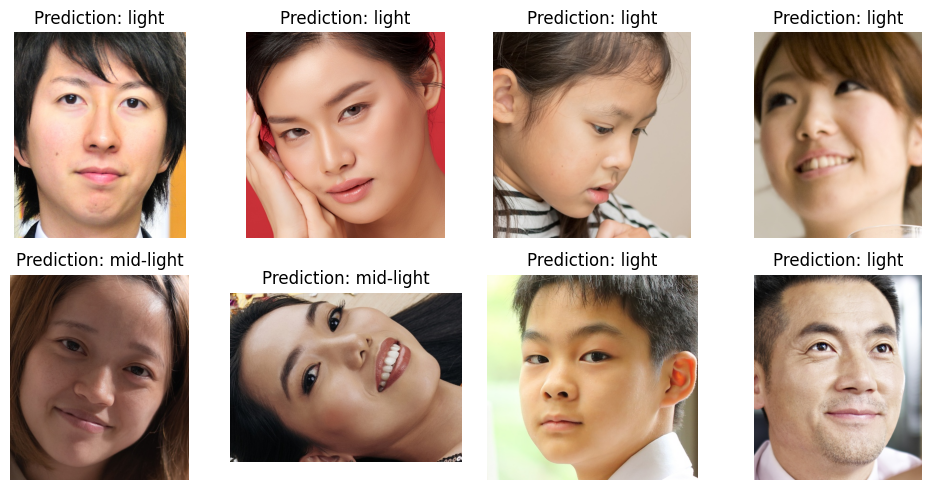

In [29]:
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
axes = axes.flatten()
for i in range(8):
  img = cv2.imread(test_dataset.image_paths[indices[i]])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  axes[i].imshow(img)
  title = f"Prediction: {categories[predictions[i]]}"

  # if labels is not None:
  #     title += f"\nTrue Label: {categories[labels[i]]}"

  axes[i].set_title(title)
  axes[i].axis('off')

plt.tight_layout()
plt.show()